<img src="../../docs/images/dlsia.png" width=600 />

# Self-supervised denoising using ensembles

**Authors:** Eric Roberts and Petrus Zwart

**E-mail:** PHZwart@lbl.gov, EJRoberts@lbl.gov

This notebook highlights some basic functionality with the dlsia package.

Here we will demonstrate how to use the randomized networks to perform self-supervised 
denoising of images corrupted by Gaussian noise. The denoising approach is based on
training a neural network to minimize a Total Variation target. We will use an ensemble
of networks to do so, will cluster these networks on the basis of their performance, 
and average the results. Because the total number of parameters in network is typically
lower than the  number of pixels, the data to parameter ratio can be more favourable. 
By using a ensemble approach, we can also produce an error estimates.

## Imports and utility functions

In [1]:
import sys
import os
import numpy as np
import tqdm

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

from dlsia.core import helpers
from dlsia.core.train_scripts import train_regression
from dlsia.core.networks import smsnet
from dlsia.viz_tools import plots

from torch.utils.data import DataLoader, TensorDataset
import einops
import matplotlib.pyplot as plt
import umap

from sklearn.cluster import KMeans
from scipy.signal import medfilt2d

### Utility functions

A number of utility functions for this notebook provided here

In [2]:
class random_atom_structure(object):
    """
    Build a random structure based from atoms.
    
    Args:    
        n_atoms (int):        The number of peaks we add in.
        
        min_distance (float): The minimum distance to its 
                              nearest neighbour.
                              
        max_distance (float): The maximal distance of a new atom to 
                              any other atom.                                  
                              
        gridXY (int):         The size of the grid on which we return.
        
        border (int):         The border-bumper: we don't want atoms 
                              on the border.
        
    Return:
        An objkect that builds coordinates that fullfill the criteria 
        stipulated above

    """
    
    def __init__(self, 
                 n_atoms: int, 
                 min_distance: float, 
                 max_distance: float,
                 gridXY: int = 128,
                 border: int = 20, 
                 max_tries = 100):
        """
        Args:    
            n_atoms (int):        The number of peaks we add in.

            min_distance (float): The minimum distance to its 
                                  nearest neighbour.
                                  
            max_distance (float): The maximal distance of a new atom to 
                                  any other atom.

            gridXY (int):         The size of the grid on which we return.

            border (int):         The border-bumper: we don't want atoms 
                                  on the border.
                                  
            max_tries (int):      How many tries we are willing to take.
            

        Return:
            An object that builds coordinates that fullfill the criteria 
            stipulated above

        """
        
        self.n_atoms = n_atoms
        self.min_distance = min_distance
        self.max_distance = max_distance
        self.gridXY = gridXY
        self.border = border
        self.max_tries = max_tries
        
    def random_xy(self):
        """
        Get a random vector
        """
        this_x = np.random.uniform(self.border, self.gridXY-self.border) 
        this_y = np.random.uniform(self.border, self.gridXY-self.border) 
        return np.array([[this_x, this_y]])
    
    def draw(self):
        """
        Construct a random structure with parameters given above.
        Args:
            None
        Output:
            An np.array of the rights size 
        """        
        
        coordinates = None
        for ii in range(self.n_atoms):
            ok = False
            count=0
            while not ok:
                xy = self.random_xy()                
                if coordinates is None:
                    coordinates = xy
                    ok = True
                else:
                    dd = coordinates - xy
                    dd = np.sum(dd*dd, axis=1)
                    observed_min_distance = np.min(dd)
                    if observed_min_distance > self.min_distance:
                        if observed_min_distance < self.max_distance:
                            ok = True
                            coordinates = np.concatenate([coordinates, xy])
                count += 1
                if count > self.max_tries:
                    ok = True
                    
        mxy = np.mean(coordinates, axis=0)
        offset = np.array([self.gridXY,self.gridXY])/2.0
        return coordinates-mxy+offset
                    
                    
def build_density(coordinates: np.array,
                  sigma: float, 
                  gridXY: int,
                  cut: float):
    """
    Take a set of coordinates and convert it into a density.
    
    Args:
        coordinates (np.array( (n_atoms, 2) )): coordinates
        
        sigma (float): the width of the gaussian
        
        gridXY (int): the grid size        
        
    Return:
        A 2D array with the desired image
    
    """
    
    result = np.zeros((gridXY,gridXY))
    x = np.linspace(0,gridXY,gridXY)
    X,Y = np.meshgrid(x,x)
    for atom in coordinates:
        this_x, this_y = atom
        Dsq = (X-this_x)**2 + (Y-this_y)**2
        partial_map = np.exp( -Dsq / (2.0 * sigma**2.0 ) )
        result += partial_map
    sel = result > cut
    result[sel]=1.0
    result[~sel]=0.0
    return result

## Create data

In [3]:
n_atoms = 80
min_distance = 1500
max_distance = 5700
gridXY = 512
border = 60
sigma = 12.5
noise_level=1.50

RAS_obj=random_atom_structure(n_atoms=n_atoms,
                              min_distance=min_distance,
                              max_distance=max_distance,
                              gridXY=gridXY,
                              border=border)

xy = RAS_obj.draw()

this_map1 = build_density(coordinates=xy,
                         sigma=sigma, 
                         gridXY=gridXY,
                         cut=0.75)

noise_map1 = (np.random.normal(0,noise_level, this_map1.shape))

this_map2 = build_density(coordinates=xy,
                         sigma=sigma, 
                         gridXY=gridXY,
                         cut=0.75)

noise_map2 = (np.random.normal(0,noise_level, this_map2.shape))



### View data

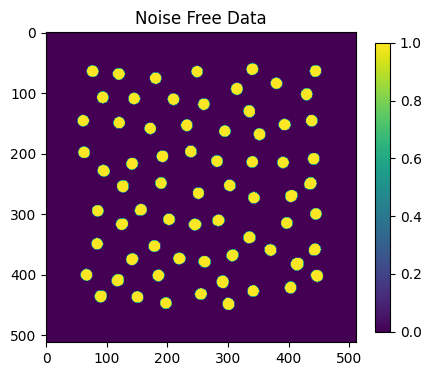

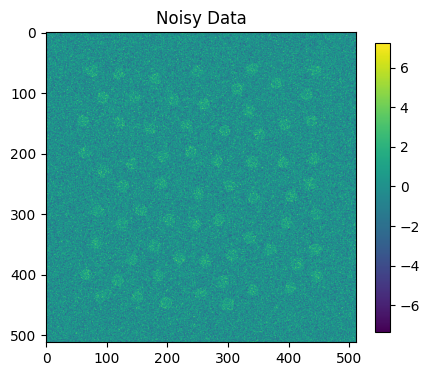

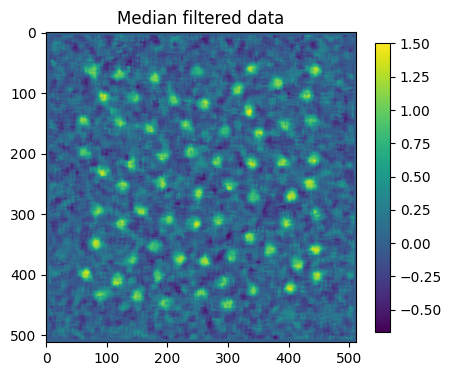

In [4]:
plt.figure(figsize=(5,5))
plt.title("Noise Free Data")
plt.imshow(this_map1)
plt.colorbar(shrink=0.75)
plt.show()

plt.figure(figsize=(5,5))
plt.title("Noisy Data")
plt.imshow(this_map1+noise_map1)
plt.colorbar(shrink=0.75)
plt.show()

plt.figure(figsize=(5,5))
plt.title("Median filtered data")
plt.imshow(medfilt2d(this_map1+noise_map1, 11))
plt.colorbar(shrink=0.75)
plt.show()


## Create networks and train

### Total variational loss

We define our own custom loss function for our networks to minimization. This loss function supplants the familiar mean square error and cross entropy losses commonly used for regression and segmentation/classification.

In [5]:
class tv_target(nn.Module):
    def __init__(self, smooth_target, noise_target, weight=1.0):
        super(tv_target, self).__init__()
        self.smooth_target = smooth_target
        self.noise_target = noise_target
        self.weight = weight
        
    def forward(self,inp,x):
        shape = x.shape
        result = 0.0
        result += self.weight*self.smooth_target(x[:,:,:,1:],x[:,:,:,0:-1])
        result += self.weight*self.smooth_target(x[:,:,1:,:],x[:,:,0:-1,:])
        result += self.noise_target(inp, x)
        return result
    


In [6]:
data1 = torch.Tensor(this_map1+noise_map1).unsqueeze(0).unsqueeze(0)
data2 = torch.Tensor(this_map2+noise_map2).unsqueeze(0).unsqueeze(0)
dataset = TensorDataset(data1)
dataloader = DataLoader(dataset)

### Create networks

Hyperparameters governing the degree of randomness in network structures are defined first.

In [7]:
in_channels=1
out_channels=1
num_layers = 10 
alpha =0.50 
gamma = 0 
max_k = 5 
min_k = 5
hidden_out_channels = [5] 
dilation_choices = [1,2,3,4,5] 

In [8]:
nets = []
N_networks = 25

for ii in range(N_networks):

    layer_probabilities={'LL_alpha':alpha,
                         'LL_gamma': gamma,
                         'LL_max_degree':max_k,
                         'LL_min_degree':min_k,
                         'IL': 0.1,
                         'LO': 0.1,
                         'IO': False}
    sizing_settings = {'stride_base':2,
                       'min_power':0,
                       'max_power':0}
    dilation_mode = "Edges"
    network_type = "Regression_Sigmoid"
    network_mode = "Full"
    netSMS = smsnet.random_SMS_network(in_channels=in_channels,
                                       out_channels=out_channels,
                                       layers=num_layers,
                                       dilation_choices=dilation_choices,
                                       hidden_out_channels=hidden_out_channels,
                                       layer_probabilities=layer_probabilities,
                                       sizing_settings = sizing_settings,
                                       dilation_mode=dilation_mode,
                                       network_type=network_type,
                                       network_mode=network_mode
                                      )
    pytorch_total_params = sum(p.numel() for p in netSMS.parameters() if p.requires_grad)
    print("Total number of refineable parameters: ", pytorch_total_params)
    nets.append(netSMS)

Total number of refineable parameters:  13140
Total number of refineable parameters:  13180
Total number of refineable parameters:  9945
Total number of refineable parameters:  16755
Total number of refineable parameters:  11345


Total number of refineable parameters:  18795
Total number of refineable parameters:  11505
Total number of refineable parameters:  17165
Total number of refineable parameters:  13955
Total number of refineable parameters:  12225
Total number of refineable parameters:  14340
Total number of refineable parameters:  15415
Total number of refineable parameters:  12805
Total number of refineable parameters:  10725
Total number of refineable parameters:  12080
Total number of refineable parameters:  13505
Total number of refineable parameters:  10860
Total number of refineable parameters:  11117
Total number of refineable parameters:  13210
Total number of refineable parameters:  9565
Total number of refineable parameters:  9835
Total number of refineable parameters:  14325
Total number of refineable parameters:  11600
Total number of refineable parameters:  10910
Total number of refineable parameters:  18070


### Training loop

We define a custom training lsoop first.

In [9]:
def simple_train_loop(net, dataloader, optim, crit, epochs, device):
    for ii in range(epochs):
        value = 0.0
        for batch in dataloader:
            inp = batch[0]
            inp = inp.to(device)

            x = net(inp)
            
            loss = crit(inp,x)
            value += loss.item()
            if (ii+1) % epochs ==0:
                print("Epoch", ii, "Loss", loss.item())
                
            optim.zero_grad()
            loss.backward()
            optim.step()
    return value

In [10]:
obtained_target_values = []
for net in nets:
    epochs = 50                        
    criterion_noise = nn.MSELoss()   
    criterion_tv = nn.L1Loss()
    weight=2.5
    combo_crit = tv_target(criterion_tv,criterion_noise, weight)
    LEARNING_RATE = 1e-2
    optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
    device = helpers.get_device()
    res = simple_train_loop(net.to(device), 
                      dataloader, 
                      optimizer, 
                      combo_crit, 
                      epochs, 
                      device)
    obtained_target_values.append(res)

Epoch 49 Loss 2.2903685569763184


Epoch 49 Loss 2.293128252029419


Epoch 49 Loss 2.2999167442321777


Epoch 49 Loss 2.3059940338134766


Epoch 49 Loss 2.2927701473236084


Epoch 49 Loss 2.2938392162323


Epoch 49 Loss 2.2998194694519043


Epoch 49 Loss 2.2990071773529053


Epoch 49 Loss 2.291795492172241


Epoch 49 Loss 2.2963905334472656


Epoch 49 Loss 2.2961220741271973


Epoch 49 Loss 2.294356346130371


Epoch 49 Loss 2.2918319702148438


Epoch 49 Loss 2.2986533641815186


Epoch 49 Loss 2.2950170040130615


Epoch 49 Loss 2.3031492233276367


Epoch 49 Loss 2.293179512023926


Epoch 49 Loss 2.301177740097046


Epoch 49 Loss 2.296251058578491


Epoch 49 Loss 2.314724922180176


Epoch 49 Loss 2.2965447902679443


Epoch 49 Loss 2.29355788230896


Epoch 49 Loss 2.311861276626587


Epoch 49 Loss 2.293119430541992


Epoch 49 Loss 2.2987704277038574


## Reconstruction and network evaluation

In [11]:
recons = []
with torch.no_grad():
    for net in nets:
        dn = net.cpu()(data1)
        recons.append(dn.numpy()[0,0])        
recons = einops.rearrange(recons, "N Y X -> N Y X")        

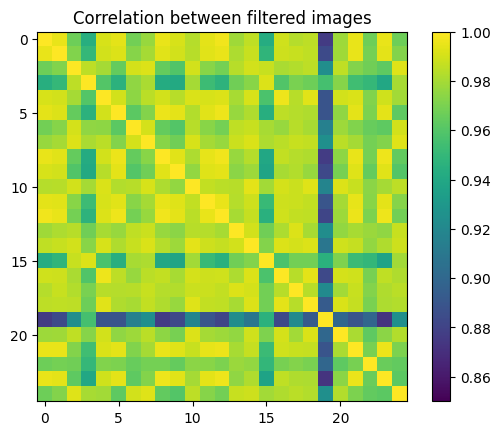

/home/ejroberts/anaconda3/envs/dlsia/lib/python3.9/site-packages/umap/umap_.py:1772: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(


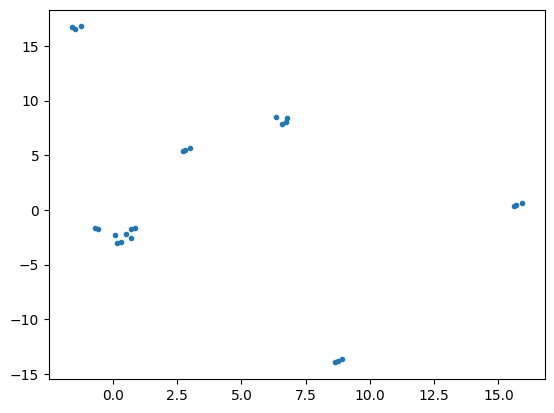

In [12]:
cc_mat = np.zeros((N_networks,N_networks))
for ii in range(N_networks):
    for jj in range(N_networks):
        this_cc = np.corrcoef( recons[ii].flatten(), recons[jj].flatten())
        cc_mat[ii,jj]=this_cc[0,1]
        
plt.imshow(cc_mat, vmin=0.85,vmax=1.0)
plt.title("Correlation between filtered images")
plt.colorbar()
plt.show()

def cc_metric(a,b):
    results = []
    for aa,bb in zip(a,b):
        tmp = (1.0 - cc_mat[int(aa),int(bb)])
        results.append(tmp)
    results = np.array(results)
    return results

X = np.arange(N_networks).astype(int).reshape(-1,1)
mapper = umap.UMAP(min_dist=0, n_neighbors=2, metric=cc_metric)
U = mapper.fit_transform(X)
plt.plot(U[:,0], U[:,1], '.')
plt.show()

/home/ejroberts/anaconda3/envs/dlsia/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


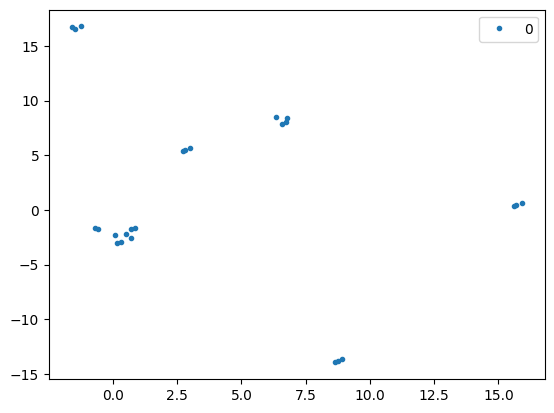

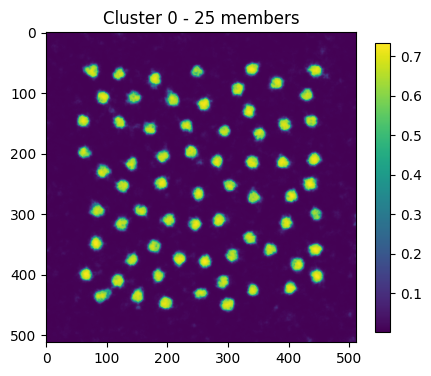

In [13]:
n_cluster=1
cobj = KMeans(n_clusters=n_cluster)
cluster = cobj.fit_predict(U)

means = []
stds = []
cluster_size = []
cluster_name = np.arange(n_cluster).astype(int)

for ii in range(n_cluster):
    sel = cluster==ii
    plt.plot(U[sel,0], U[sel,1], '.')
    m = np.mean(recons[sel,...], axis=0)
    s = np.std(recons[sel,...], axis=0)
    means.append(m)
    stds.append(s)  
    cluster_size.append(np.sum(sel))
plt.legend(cluster_name)
plt.show()


for m,s,ss,cn in zip(means, stds, cluster_size, cluster_name):
    plt.figure(figsize=(5,5))
    plt.imshow(m)
    plt.title("Cluster %i - %i members"%(cn,ss))
    plt.colorbar(shrink=0.75)
        

In [14]:
sel = np.where(cluster == 0)[0]
print(sel)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]


In [15]:
these_nets = []
for ii in sel:
    these_nets.append(nets[ii])

In [16]:
new_recons = []
with torch.no_grad():
    for net in nets:
        dn = net.cpu()(data2)
        dn = dn / torch.max(dn)
        new_recons.append(dn.numpy()[0,0])        
new_recons = einops.rearrange(new_recons, "N Y X -> N Y X")  
new_mean = np.mean(new_recons, axis=0) 
new_std = np.std(new_recons, axis=0)

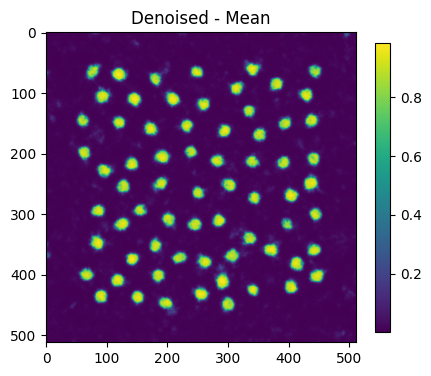

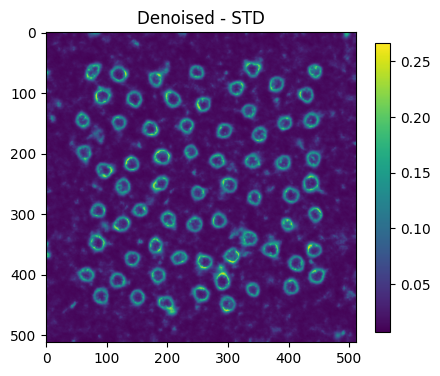

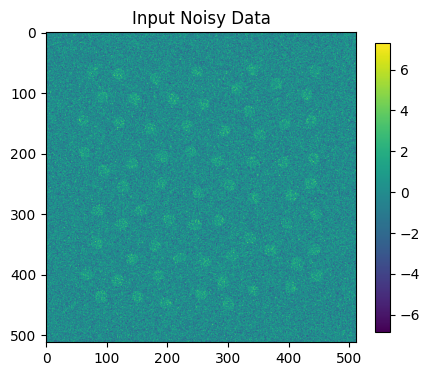

In [17]:
plt.figure(figsize=(5,5))
plt.imshow(new_mean)
plt.title("Denoised - Mean")
plt.colorbar(shrink=0.75)
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(new_std)
plt.title("Denoised - STD")
plt.colorbar(shrink=0.75)
plt.show()


plt.figure(figsize=(5,5))
plt.imshow( this_map2+noise_map2 )
plt.title("Input Noisy Data")
plt.colorbar(shrink=0.75)
plt.show()